# Presentation of the implementation of the Louvain and Leiden algorithms

For starters, import the dependencies; the NetworkX python library for handling graphs and the algorithm implementations.

In [1]:
import random

import networkx as nx
import matplotlib.pyplot as plt

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity

# Seed random number generator to make this notebook reproducible
random.seed(0)

## Zachary's Karate Club Graph

In [2]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=1)

_Zachary's Karate Club_ is a graph that represents the social structure in a Karate club.
The nodes represent instructors and students in the club.
There are two instructors, "Mr. Hi" and the "Officer", as well as 32 students.
An edge between two nodes indicates that these people interacted at some point.

After a conflict between the instructors, the club split into two groups, one around around each of the instructors.
Let's see whether we can use the detected communities to predict, which students will follow each of the instructors!

In order to facilitate drawing graphs, we'll use the following function, which indicates communities in the graph by coloring the nodes according to their community's color:

In [3]:
def draw_graph(G, pos=None, communities=None, labels=None, force_color={}, file=None):
    if communities:
        # Create a color map
        node_color = [0 for _ in G]

        for i, community in enumerate(communities):
            for node in community:
                node_color[node] = i

        for k, v in force_color.items():
            node_color[k] = v

        nx.draw(G, pos, node_color=node_color, cmap=plt.cm.rainbow, labels=labels)
    else:
        nx.draw(G, pos, labels=labels)

    if file:
        plt.savefig(file, bbox_inches='tight')

    plt.show()

With the drawing function given above, we can draw the Karate Club graph:

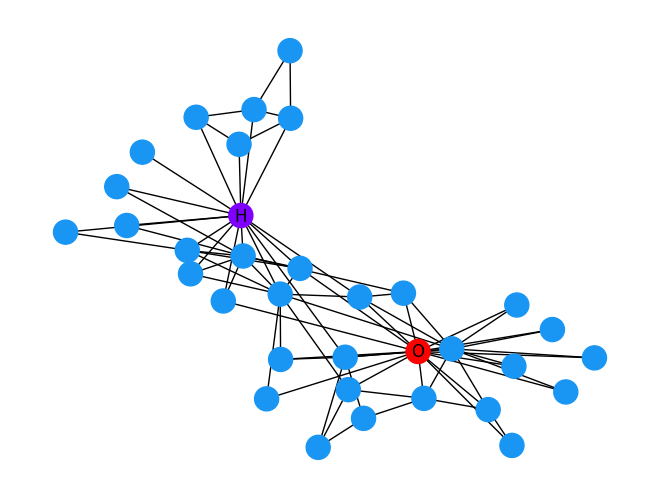

In [4]:
force_color = {0: -1, 33: 4}  # Mark Mr. Hi / the officer with dark and light blue respectively.
labels = {0: "H", 33: "O"}
draw_graph(G, pos, [set(G.nodes())], labels, force_color, file='figures/karate-sample.pdf')

The two rivaling trainers are indicated with their initials, "H" and "O", was well as their own colors; Mr. Hi with a purple node and the officer with a red one.

## Louvain

For this graph `G`, we calculate a partition into communities using Modularity as the quality function and the Louvain algorithm. 
For the modularity we use a resolution of $\gamma = 1$.

In [5]:
𝓗 = Modularity(1)
𝓟 = louvain(G, 𝓗, weight="weight")

The result of the Leiden algorithm is shown below.

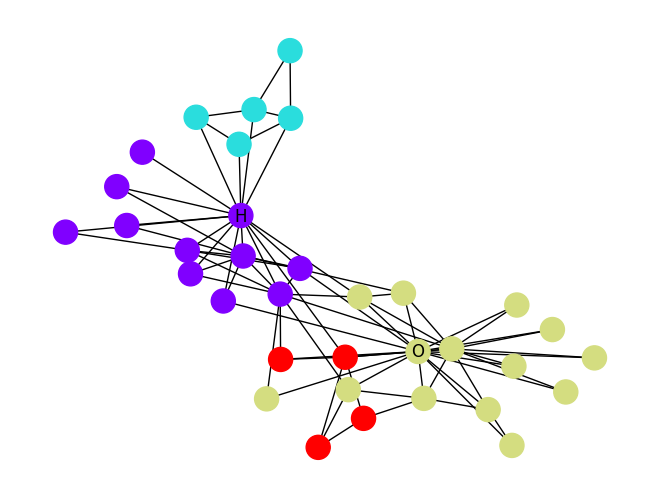

Modularity after Louvain: 𝓗(𝓟)=0.4438541256723075


In [6]:
draw_graph(G, pos, 𝓟.communities, labels)
print(f"Modularity after Louvain: {𝓗(𝓟)=}")

The Louvain algorithm identified four communities in this graph, identified by the red, purple, ochre, and light blue nodes:  

It is easy to see that the violet community is centered on Mr. Hi and that the ochre community is centered on the officer.
Furthermore, there is a community, identified by the light blue nodes, that only has connections to Mr. Hi, but not to any other students.

## Leiden

We now apply the Leiden algorithm to the same graph, again using Modularity with $\gamma = 1$ as a quality function:

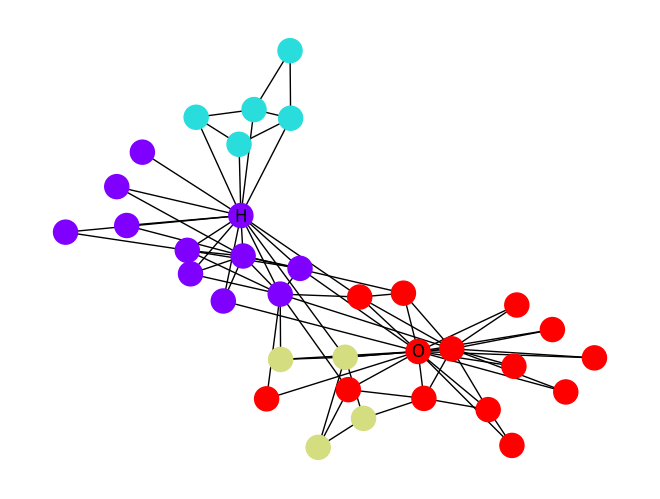

Modularity after Leiden: 𝓗(𝓠)=0.4438541256723075


In [7]:
# Calculate a new partition into communities, using Modularity and the Leiden algorithm …
𝓠 = leiden(G, 𝓗, weight="weight")
# … and draw the result:
draw_graph(G, pos, 𝓠.communities, labels, file='figures/karate-communities.pdf')
print(f"Modularity after Leiden: {𝓗(𝓠)=}")

This is the same partition (disregarding the switched colors, which stem from the way we draw the graph) as the one the Louvain algorithm arrived at, for the given quality function and graph.

## Ground Truth
Based on our plots above, we could predict that the violet community would conceivably stay with Mr. Hi, while the red one would stay with the Officer.
Similarly, the light blue group would very likely stay with Mr. Hi as well, as they have no other connection to outsiders.
The ochre community might go with either instructor.

Let us now compare our result to the groups after the split as described in Zachary's paper:

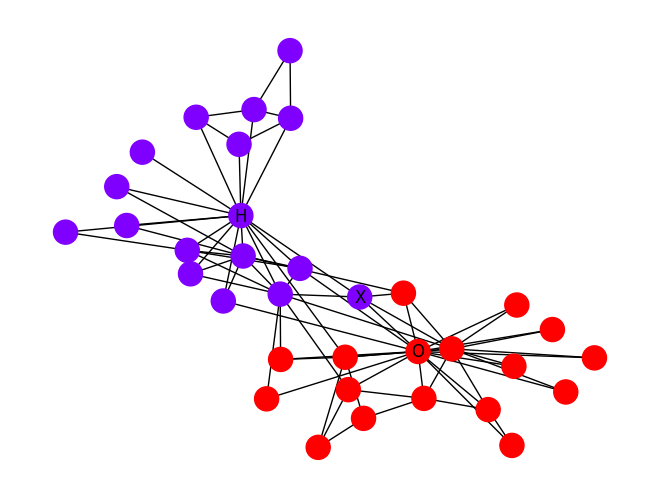

In [8]:
# Determine the reference partition …
N = G.nodes(data='club')
𝓡 = [{k for k,c in N if c == 'Mr. Hi'}, {k for k,c in N if c == 'Officer'}]

# … and draw it
draw_graph(G, pos, 𝓡, labels | {8: "X"}, file='figures/karate-ground-truth.pdf')

If we had predicted that the ochre group would join the officer, we would only have been wrong about one student, marked with an "X", who joined Mr. Hi instead of the officer as predicted.